<a href="https://www.kaggle.com/code/samithsachidanandan/ada-boost-from-scratch-in-python?scriptVersionId=270196547" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### What is AdaBoost?

AdaBoost (Adaptive Boosting) is an ensemble learning algorithm — it builds a strong classifier by combining many weak classifiers (usually decision stumps).

AdaBoost works in rounds:

1.	Start with equal weights for all training examples.

2.	Train a weak learner (e.g., a decision stump).

3.	Give the weak learner a weight (alpha) based on how well it performs.

4.	Increase the weights of the misclassified samples so the next learner focuses more on them.

5.	Repeat for several rounds.

In the end, predictions from all weak learners are combined using their alphas.


### Importing the necessary libraries

In [1]:
import numpy as np

### Decision Stump Class

In [2]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions

### AdaBoost Class

In [3]:
class Adaboost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.clfs = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []

        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")

            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred




### Testing 

In [4]:

if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    y[y == 0] = -1

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5
    )

    # Adaboost classification with 5 weak classifiers
    clf = Adaboost(n_clf=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy(y_test, y_pred)
    print("Accuracy:", acc)

Accuracy: 0.9736842105263158


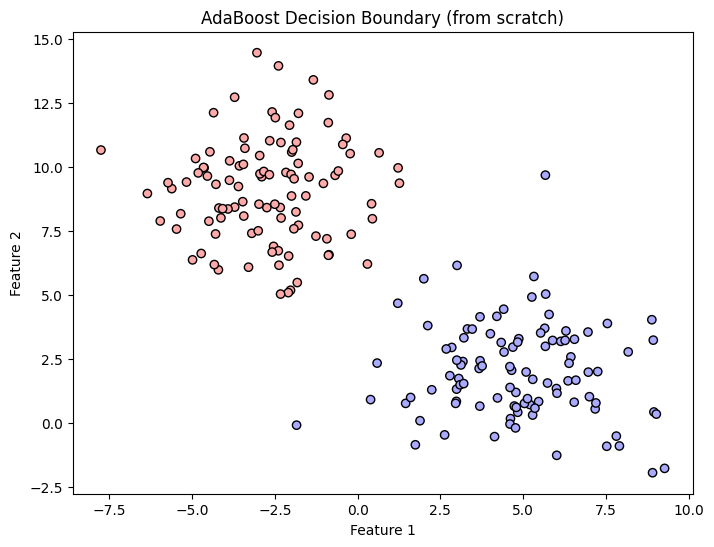

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap


X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=2)
y[y == 0] = -1


clf = Adaboost(n_clf=5)
clf.fit(X, y)
y_pred = clf.predict(X)


plt.figure(figsize=(8,6))
cmap = ListedColormap(["#FFAAAA", "#AAAAFF"])
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap, edgecolor='k')
plt.title("AdaBoost Decision Boundary (from scratch)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
